In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
from copy import copy, deepcopy

from time import time
import math

In [2]:
from pandas import DataFrame
from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import torch.distributions as distr

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
torch.cuda.set_device(5)

In [6]:
device = torch.device('cuda' if USE_CUDA else 'cpu')
device

device(type='cuda')

In [62]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [8]:
batch_size = 100

In [115]:
dataset_name = 'cifar10'

In [116]:
kwargs = {'num_workers': 0, 'pin_memory': True} if USE_CUDA else {}

if dataset_name == 'mnist':
    dataset = MNIST
elif dataset_name == 'cifar10':
    dataset = CIFAR10
else:
    raise NotImplementedError

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

Files already downloaded and verified


In [134]:
train_dataset_train, train_dataset_valid, train_labels_train, train_labels_valid = train_test_split(
    np.array(train_loader.dataset.train_data), np.array(train_loader.dataset.train_labels), 
    stratify=np.array(train_loader.dataset.train_labels), 
    train_size=100 if dataset_name == 'mnist' else 4000 if dataset_name == 'cifar10' else None
)

train_loader_train = DataLoader(
    TensorDataset(
        torch.from_numpy(
            train_dataset_train if dataset_name == 'mnist' else \
            train_dataset_train.transpose(0, 3, 1, 2) if dataset_name == 'cifar10' else None
        ).float() / 255, 
        torch.Tensor(train_labels_train).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)
train_loader_valid = DataLoader(
    TensorDataset(
        torch.from_numpy(
            train_dataset_valid if dataset_name == 'mnist' else \
            train_dataset_valid.transpose(0, 3, 1, 2) if dataset_name == 'cifar10' else None
        ).float() / 255, 
        torch.Tensor(train_labels_valid).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)


/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [136]:
train_loader_train.dataset[0][0].shape

torch.Size([3, 32, 32])

In [137]:
train_size = train_loader_train.dataset.tensors[0].shape[0]
valid_size = train_loader_valid.dataset.tensors[0].shape[0]
test_size = test_loader.dataset.test_data.shape[0]
train_size, valid_size, test_size

(4000, 46000, 10000)

In [138]:
if dataset_name == 'mnist':
    input_shape = [1, 28, 28]
elif dataset_name == 'cifar10':
    input_shape = [3, 32, 32]
else:
    raise NotImplementedError
output_size = 10

In [13]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [76]:
class DeepConv(nn.Module):
    def __init__(self, input_shape, output_size, init_num_filters=32):
        super(type(self), self).__init__()
        self.layers = nn.Sequential(
            ReshapeLayer(*input_shape),
            nn.Conv2d(input_shape[0], init_num_filters, 3, padding=1),
            nn.BatchNorm2d(init_num_filters),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(init_num_filters, init_num_filters, 3, padding=1),
            nn.BatchNorm2d(init_num_filters),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(init_num_filters, init_num_filters, 3, padding=1),
            nn.BatchNorm2d(init_num_filters),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(init_num_filters, init_num_filters * 2, 3, padding=1),
            nn.BatchNorm2d(init_num_filters * 2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(init_num_filters * 2, init_num_filters * 2, 3, padding=1),
            nn.BatchNorm2d(init_num_filters * 2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(init_num_filters * 2, init_num_filters * 2, 3, padding=1),
            nn.BatchNorm2d(init_num_filters * 2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(init_num_filters * 2, init_num_filters * 2, 3),
            nn.BatchNorm2d(init_num_filters * 2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(init_num_filters * 2, init_num_filters * 2, 1),
            nn.BatchNorm2d(init_num_filters * 2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(init_num_filters * 2, init_num_filters * 2, 1),
            nn.BatchNorm2d(init_num_filters * 2),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d((input_shape[1] // 2 // 2 - 2, input_shape[2] // 2 // 2 - 2)),
            ReshapeLayer(-1),
            nn.Linear(init_num_filters * 2, output_size)
        )
        
    def forward(self, X):
        return self.layers(X)

In [146]:
num_epochs = 1000
min_num_train_batches = 10
max_num_test_batches = 10
init_lr = 3e-4

test_accs = {}
train_accs = {}
param_counts = {}
num_filters_alts = 2 ** np.arange(2, 9, 2)

for num_filters in num_filters_alts:
    print(num_filters)
    test_accs[num_filters] = []
    train_accs[num_filters] = []
    model = DeepConv(input_shape, output_size, init_num_filters=num_filters).to(device)
    optimizer = optim.Adam(model.parameters(), lr=init_lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1/3, patience=20, verbose=True)
    loss_function = nn.CrossEntropyLoss()

    param_count = 0
    for param in model.parameters():
        param_count += param.view(-1).shape[0]
    param_counts[num_filters] = param_count
    print(param_count)

    for epoch in range(num_epochs):
        print('epoch', epoch+1)

        cum_batch_size = 0
        cum_loss = 0
        cum_acc = 0

        model.train()
        i = 0
        while i < min_num_train_batches:
            for X, y in train_loader_train:
                batch_size = X.shape[0]
                cum_batch_size += batch_size

                X, y = X.to(device), y.to(device)

                logits = model(X)

                loss = loss_function(logits, y)
                cum_loss += loss.item() * batch_size

                acc = torch.mean((torch.max(logits, dim=-1)[1] == y).float())
                cum_acc += acc.item() * batch_size

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                i += 1

        mean_train_loss = cum_loss / cum_batch_size
        mean_train_acc = cum_acc / cum_batch_size

        train_accs[num_filters].append(mean_train_acc)

        print('loss: {:.2f}    acc:{:.2f}'.format(mean_train_loss, mean_train_acc*100))

        cum_batch_size = 0
        cum_loss = 0
        cum_acc = 0

        model.eval()
        with torch.no_grad():
            for i, (X, y) in enumerate(test_loader):
                if i >= max_num_test_batches:
                    break
                batch_size = X.shape[0]
                cum_batch_size += batch_size

                X, y = X.to(device), y.to(device)

                logits = model(X)

                loss = loss_function(logits, y)
                cum_loss += loss.item() * batch_size

                acc = torch.mean((torch.max(logits, dim=-1)[1] == y).float())
                cum_acc += acc.item() * batch_size

        mean_test_loss = cum_loss / cum_batch_size
        mean_test_acc = cum_acc / cum_batch_size

        test_accs[num_filters].append(mean_test_acc)

        print('loss: {:.2f}    acc:{:.2f}'.format(mean_test_loss, mean_test_acc*100))
        
        scheduler.step(mean_train_loss)
        #if optimizer.param_groups[0]['lr'] < init_lr / 100:
        #    break

4
2810
epoch 1
loss: 2.33    acc:10.07
loss: 2.35    acc:11.40
epoch 2
loss: 2.33    acc:10.77
loss: 2.34    acc:11.30
epoch 3
loss: 2.32    acc:11.97
loss: 2.32    acc:12.90
epoch 4
loss: 2.30    acc:13.52
loss: 2.32    acc:11.70
epoch 5
loss: 2.29    acc:14.15
loss: 2.28    acc:13.40
epoch 6
loss: 2.28    acc:15.25
loss: 2.29    acc:13.50
epoch 7
loss: 2.26    acc:15.90
loss: 2.25    acc:12.90
epoch 8
loss: 2.24    acc:16.25
loss: 2.25    acc:13.60
epoch 9
loss: 2.22    acc:16.45
loss: 2.21    acc:17.70
epoch 10
loss: 2.21    acc:16.40
loss: 2.22    acc:16.20
epoch 11
loss: 2.19    acc:16.65
loss: 2.25    acc:13.20
epoch 12
loss: 2.17    acc:16.72
loss: 2.22    acc:12.30
epoch 13
loss: 2.16    acc:17.27
loss: 2.19    acc:15.60
epoch 14
loss: 2.13    acc:18.75
loss: 2.18    acc:15.30
epoch 15
loss: 2.12    acc:19.02
loss: 2.16    acc:18.30
epoch 16
loss: 2.10    acc:20.35
loss: 2.16    acc:17.80
epoch 17
loss: 2.08    acc:20.35
loss: 2.12    acc:18.20
epoch 18
loss: 2.07    acc:21.42


loss: 1.54    acc:42.32
loss: 1.71    acc:34.40
epoch 145
loss: 1.55    acc:41.07
loss: 1.83    acc:34.20
epoch 146
loss: 1.54    acc:42.50
loss: 1.73    acc:33.50
epoch 147
loss: 1.55    acc:41.05
loss: 1.73    acc:34.50
epoch 148
loss: 1.54    acc:41.50
loss: 1.76    acc:33.40
epoch 149
loss: 1.53    acc:41.70
loss: 1.82    acc:31.00
epoch 150
loss: 1.53    acc:42.35
loss: 1.81    acc:33.20
epoch 151
loss: 1.53    acc:42.02
loss: 1.79    acc:34.00
epoch 152
loss: 1.54    acc:41.40
loss: 1.75    acc:34.10
epoch 153
loss: 1.53    acc:41.22
loss: 1.71    acc:36.50
epoch 154
loss: 1.53    acc:41.70
loss: 1.70    acc:35.20
epoch 155
loss: 1.53    acc:41.95
loss: 1.78    acc:33.80
epoch 156
loss: 1.52    acc:42.02
loss: 1.68    acc:35.90
epoch 157
loss: 1.52    acc:43.35
loss: 1.73    acc:35.20
epoch 158
loss: 1.52    acc:43.12
loss: 1.76    acc:34.60
epoch 159
loss: 1.53    acc:42.37
loss: 1.82    acc:32.60
epoch 160
loss: 1.52    acc:43.27
loss: 1.88    acc:32.50
epoch 161
loss: 1.52    

loss: 1.52    acc:45.20
epoch 286
loss: 1.43    acc:45.10
loss: 1.76    acc:40.90
epoch 287
loss: 1.41    acc:47.27
loss: 1.55    acc:43.20
epoch 288
loss: 1.42    acc:45.87
loss: 1.64    acc:40.10
epoch 289
loss: 1.44    acc:45.32
loss: 1.59    acc:41.00
epoch 290
loss: 1.43    acc:46.02
loss: 1.64    acc:41.90
epoch 291
loss: 1.43    acc:45.35
loss: 1.50    acc:46.40
epoch 292
loss: 1.42    acc:47.35
loss: 1.64    acc:39.70
epoch 293
loss: 1.43    acc:46.00
loss: 1.57    acc:41.70
epoch 294
loss: 1.42    acc:45.77
loss: 1.60    acc:40.90
epoch 295
loss: 1.42    acc:46.50
loss: 1.64    acc:43.10
epoch 296
loss: 1.43    acc:46.42
loss: 1.64    acc:41.70
epoch 297
loss: 1.42    acc:46.02
loss: 1.55    acc:44.70
epoch 298
loss: 1.41    acc:46.40
loss: 1.64    acc:41.00
epoch 299
loss: 1.42    acc:47.05
loss: 1.59    acc:43.90
epoch 300
loss: 1.42    acc:46.40
loss: 1.62    acc:42.50
epoch 301
loss: 1.42    acc:46.60
loss: 1.52    acc:43.40
epoch 302
loss: 1.43    acc:46.30
loss: 1.57    

loss: 1.37    acc:48.30
loss: 1.56    acc:44.30
epoch 426
loss: 1.37    acc:48.30
loss: 1.52    acc:46.40
epoch 427
loss: 1.38    acc:48.80
loss: 1.52    acc:44.40
epoch 428
loss: 1.38    acc:47.62
loss: 1.52    acc:44.50
epoch 429
loss: 1.36    acc:49.15
loss: 1.64    acc:41.00
epoch 430
loss: 1.37    acc:47.75
loss: 1.52    acc:43.90
epoch 431
loss: 1.38    acc:48.47
loss: 1.56    acc:45.10
epoch 432
loss: 1.38    acc:48.77
loss: 1.54    acc:43.70
epoch 433
loss: 1.38    acc:48.52
loss: 1.59    acc:42.80
epoch 434
loss: 1.37    acc:47.75
loss: 1.50    acc:43.20
epoch 435
loss: 1.37    acc:48.77
loss: 1.54    acc:42.80
epoch 436
loss: 1.37    acc:48.55
loss: 1.55    acc:46.40
epoch 437
loss: 1.38    acc:48.50
loss: 1.57    acc:42.40
epoch 438
loss: 1.38    acc:48.45
loss: 1.56    acc:42.50
epoch 439
loss: 1.38    acc:48.85
loss: 1.56    acc:45.60
epoch 440
loss: 1.36    acc:48.62
loss: 1.62    acc:43.00
epoch 441
loss: 1.37    acc:48.12
loss: 1.53    acc:45.40
epoch 442
loss: 1.37    

loss: 1.37    acc:48.62
loss: 1.52    acc:43.80
epoch 562
loss: 1.37    acc:48.50
loss: 1.52    acc:43.70
epoch 563
loss: 1.37    acc:48.75
loss: 1.50    acc:45.80
epoch 564
loss: 1.37    acc:48.82
loss: 1.56    acc:43.90
epoch 565
loss: 1.37    acc:48.62
loss: 1.51    acc:46.50
epoch 566
loss: 1.36    acc:48.47
loss: 1.56    acc:43.80
epoch 567
loss: 1.37    acc:48.57
loss: 1.59    acc:42.50
epoch 568
loss: 1.38    acc:48.10
loss: 1.59    acc:41.60
epoch 569
loss: 1.37    acc:48.42
loss: 1.55    acc:43.90
Epoch   568: reducing learning rate of group 0 to 1.5242e-08.
epoch 570
loss: 1.37    acc:48.57
loss: 1.55    acc:44.20
epoch 571
loss: 1.38    acc:47.90
loss: 1.56    acc:43.10
epoch 572
loss: 1.38    acc:48.47
loss: 1.59    acc:42.50
epoch 573
loss: 1.38    acc:49.22
loss: 1.55    acc:45.80
epoch 574
loss: 1.37    acc:48.65
loss: 1.58    acc:43.80
epoch 575
loss: 1.37    acc:48.37
loss: 1.61    acc:43.10
epoch 576
loss: 1.38    acc:49.17
loss: 1.57    acc:40.40
epoch 577
loss: 1.36

loss: 1.62    acc:40.20
epoch 701
loss: 1.38    acc:48.12
loss: 1.69    acc:42.10
epoch 702
loss: 1.37    acc:48.35
loss: 1.60    acc:44.90
epoch 703
loss: 1.38    acc:48.32
loss: 1.63    acc:39.70
epoch 704
loss: 1.38    acc:47.62
loss: 1.63    acc:40.40
epoch 705
loss: 1.37    acc:48.35
loss: 1.52    acc:46.60
epoch 706
loss: 1.37    acc:47.62
loss: 1.64    acc:42.10
epoch 707
loss: 1.37    acc:48.00
loss: 1.52    acc:46.10
epoch 708
loss: 1.37    acc:47.67
loss: 1.58    acc:42.60
epoch 709
loss: 1.37    acc:47.02
loss: 1.58    acc:41.30
epoch 710
loss: 1.38    acc:48.42
loss: 1.63    acc:42.60
epoch 711
loss: 1.36    acc:48.55
loss: 1.53    acc:45.30
epoch 712
loss: 1.37    acc:48.85
loss: 1.57    acc:43.40
epoch 713
loss: 1.38    acc:48.67
loss: 1.61    acc:41.40
epoch 714
loss: 1.37    acc:49.32
loss: 1.63    acc:41.90
epoch 715
loss: 1.37    acc:48.37
loss: 1.53    acc:45.10
epoch 716
loss: 1.37    acc:48.52
loss: 1.53    acc:43.30
epoch 717
loss: 1.38    acc:47.65
loss: 1.50    

loss: 1.38    acc:47.35
loss: 1.57    acc:43.40
epoch 843
loss: 1.38    acc:47.52
loss: 1.52    acc:43.40
epoch 844
loss: 1.37    acc:47.87
loss: 1.54    acc:45.60
epoch 845
loss: 1.37    acc:48.45
loss: 1.57    acc:45.50
epoch 846
loss: 1.38    acc:47.70
loss: 1.62    acc:42.90
epoch 847
loss: 1.37    acc:48.85
loss: 1.59    acc:43.30
epoch 848
loss: 1.38    acc:48.75
loss: 1.60    acc:40.70
epoch 849
loss: 1.37    acc:49.30
loss: 1.52    acc:45.20
epoch 850
loss: 1.37    acc:49.55
loss: 1.49    acc:47.30
epoch 851
loss: 1.37    acc:48.30
loss: 1.55    acc:44.00
epoch 852
loss: 1.36    acc:49.30
loss: 1.56    acc:42.40
epoch 853
loss: 1.38    acc:48.47
loss: 1.55    acc:44.70
epoch 854
loss: 1.37    acc:48.30
loss: 1.57    acc:42.70
epoch 855
loss: 1.38    acc:48.65
loss: 1.50    acc:44.70
epoch 856
loss: 1.36    acc:48.62
loss: 1.61    acc:42.40
epoch 857
loss: 1.37    acc:48.57
loss: 1.51    acc:45.50
epoch 858
loss: 1.38    acc:48.12
loss: 1.57    acc:45.30
epoch 859
loss: 1.37    

loss: 1.57    acc:43.80
epoch 984
loss: 1.37    acc:48.77
loss: 1.62    acc:43.80
epoch 985
loss: 1.39    acc:48.97
loss: 1.60    acc:40.80
epoch 986
loss: 1.37    acc:48.17
loss: 1.62    acc:42.50
epoch 987
loss: 1.37    acc:49.17
loss: 1.57    acc:44.40
epoch 988
loss: 1.37    acc:49.07
loss: 1.51    acc:46.00
epoch 989
loss: 1.36    acc:49.20
loss: 1.57    acc:43.70
epoch 990
loss: 1.37    acc:48.55
loss: 1.60    acc:42.90
epoch 991
loss: 1.39    acc:48.00
loss: 1.60    acc:43.10
epoch 992
loss: 1.37    acc:48.65
loss: 1.55    acc:44.60
epoch 993
loss: 1.39    acc:47.80
loss: 1.60    acc:41.50
epoch 994
loss: 1.36    acc:49.70
loss: 1.59    acc:42.60
epoch 995
loss: 1.38    acc:48.27
loss: 1.66    acc:41.60
epoch 996
loss: 1.37    acc:49.42
loss: 1.55    acc:44.80
epoch 997
loss: 1.36    acc:49.50
loss: 1.54    acc:43.80
epoch 998
loss: 1.37    acc:48.65
loss: 1.54    acc:42.80
epoch 999
loss: 1.36    acc:48.90
loss: 1.60    acc:44.30
epoch 1000
loss: 1.38    acc:48.05
loss: 1.52   

loss: 1.06    acc:65.20
epoch 127
loss: 0.75    acc:73.27
loss: 1.24    acc:60.20
epoch 128
loss: 0.76    acc:73.07
loss: 1.21    acc:61.40
epoch 129
loss: 0.75    acc:73.30
loss: 1.12    acc:60.00
epoch 130
loss: 0.74    acc:74.42
loss: 1.14    acc:61.00
epoch 131
loss: 0.74    acc:72.90
loss: 1.08    acc:62.50
epoch 132
loss: 0.73    acc:73.85
loss: 1.18    acc:59.90
epoch 133
loss: 0.74    acc:73.50
loss: 1.19    acc:61.00
epoch 134
loss: 0.73    acc:74.45
loss: 1.06    acc:62.10
epoch 135
loss: 0.74    acc:73.62
loss: 1.09    acc:60.40
epoch 136
loss: 0.73    acc:73.47
loss: 1.08    acc:63.60
epoch 137
loss: 0.73    acc:74.25
loss: 1.15    acc:60.40
epoch 138
loss: 0.72    acc:74.72
loss: 1.13    acc:59.90
epoch 139
loss: 0.70    acc:74.97
loss: 1.10    acc:61.40
epoch 140
loss: 0.72    acc:73.65
loss: 1.16    acc:62.70
epoch 141
loss: 0.72    acc:74.22
loss: 1.18    acc:61.80
epoch 142
loss: 0.71    acc:74.55
loss: 1.24    acc:60.00
epoch 143
loss: 0.70    acc:74.92
loss: 1.06    

loss: 0.50    acc:82.42
loss: 1.23    acc:64.60
epoch 269
loss: 0.50    acc:81.47
loss: 1.10    acc:66.20
epoch 270
loss: 0.49    acc:82.27
loss: 1.20    acc:63.70
epoch 271
loss: 0.49    acc:82.32
loss: 1.09    acc:64.80
epoch 272
loss: 0.49    acc:81.80
loss: 1.01    acc:69.40
epoch 273
loss: 0.49    acc:81.82
loss: 1.10    acc:65.90
epoch 274
loss: 0.49    acc:81.45
loss: 1.18    acc:64.20
epoch 275
loss: 0.49    acc:82.45
loss: 1.19    acc:63.80
epoch 276
loss: 0.48    acc:82.67
loss: 1.16    acc:64.80
epoch 277
loss: 0.48    acc:82.77
loss: 1.26    acc:63.20
epoch 278
loss: 0.49    acc:81.95
loss: 1.13    acc:65.20
epoch 279
loss: 0.48    acc:82.77
loss: 1.08    acc:67.40
epoch 280
loss: 0.48    acc:82.70
loss: 1.22    acc:64.30
epoch 281
loss: 0.48    acc:82.87
loss: 1.15    acc:63.10
epoch 282
loss: 0.47    acc:82.92
loss: 1.17    acc:64.90
epoch 283
loss: 0.49    acc:81.82
loss: 1.29    acc:63.30
epoch 284
loss: 0.47    acc:82.62
loss: 1.22    acc:65.20
epoch 285
loss: 0.48    

loss: 1.20    acc:66.30
epoch 410
loss: 0.38    acc:85.67
loss: 1.12    acc:67.60
epoch 411
loss: 0.39    acc:85.62
loss: 1.23    acc:66.70
epoch 412
loss: 0.39    acc:85.62
loss: 1.32    acc:64.10
epoch 413
loss: 0.37    acc:87.02
loss: 1.33    acc:65.00
epoch 414
loss: 0.40    acc:84.80
loss: 1.21    acc:66.40
epoch 415
loss: 0.38    acc:86.37
loss: 1.34    acc:64.20
epoch 416
loss: 0.38    acc:86.50
loss: 1.39    acc:63.50
epoch 417
loss: 0.38    acc:86.07
loss: 1.31    acc:64.50
epoch 418
loss: 0.38    acc:85.82
loss: 1.31    acc:63.80
epoch 419
loss: 0.38    acc:85.80
loss: 1.28    acc:64.50
epoch 420
loss: 0.37    acc:86.35
loss: 1.31    acc:66.20
epoch 421
loss: 0.41    acc:85.97
loss: 1.33    acc:62.60
epoch 422
loss: 0.39    acc:85.87
loss: 1.26    acc:65.10
epoch 423
loss: 0.39    acc:85.65
loss: 1.18    acc:67.40
epoch 424
loss: 0.37    acc:86.80
loss: 1.26    acc:63.70
epoch 425
loss: 0.39    acc:86.02
loss: 1.33    acc:64.00
epoch 426
loss: 0.37    acc:86.55
loss: 1.31    

loss: 0.27    acc:90.20
loss: 1.32    acc:66.60
epoch 551
loss: 0.26    acc:90.45
loss: 1.36    acc:64.90
epoch 552
loss: 0.27    acc:90.75
loss: 1.24    acc:68.10
epoch 553
loss: 0.26    acc:90.50
loss: 1.44    acc:63.00
epoch 554
loss: 0.26    acc:91.10
loss: 1.30    acc:66.60
epoch 555
loss: 0.28    acc:89.90
loss: 1.30    acc:65.10
epoch 556
loss: 0.27    acc:90.87
loss: 1.25    acc:68.30
epoch 557
loss: 0.27    acc:90.40
loss: 1.36    acc:67.50
epoch 558
loss: 0.28    acc:90.22
loss: 1.28    acc:66.40
epoch 559
loss: 0.27    acc:89.92
loss: 1.35    acc:66.10
epoch 560
loss: 0.26    acc:90.90
loss: 1.15    acc:69.20
epoch 561
loss: 0.26    acc:90.92
loss: 1.34    acc:66.70
epoch 562
loss: 0.26    acc:90.42
loss: 1.30    acc:66.40
epoch 563
loss: 0.26    acc:90.87
loss: 1.28    acc:66.00
epoch 564
loss: 0.28    acc:90.05
loss: 1.28    acc:67.10
epoch 565
loss: 0.28    acc:89.85
loss: 1.40    acc:65.90
epoch 566
loss: 0.29    acc:89.47
loss: 1.27    acc:66.80
Epoch   565: reducing le

loss: 1.24    acc:67.90
epoch 689
loss: 0.23    acc:92.32
loss: 1.33    acc:68.60
epoch 690
loss: 0.24    acc:91.77
loss: 1.32    acc:67.10
epoch 691
loss: 0.23    acc:91.85
loss: 1.26    acc:66.80
epoch 692
loss: 0.23    acc:92.05
loss: 1.28    acc:65.30
epoch 693
loss: 0.24    acc:91.42
loss: 1.34    acc:66.90
epoch 694
loss: 0.23    acc:92.47
loss: 1.24    acc:69.60
epoch 695
loss: 0.23    acc:91.97
loss: 1.28    acc:69.30
epoch 696
loss: 0.24    acc:91.05
loss: 1.29    acc:68.10
epoch 697
loss: 0.23    acc:91.85
loss: 1.20    acc:67.90
epoch 698
loss: 0.24    acc:91.17
loss: 1.26    acc:67.90
epoch 699
loss: 0.24    acc:91.32
loss: 1.24    acc:68.70
epoch 700
loss: 0.22    acc:92.47
loss: 1.25    acc:69.30
epoch 701
loss: 0.24    acc:91.72
loss: 1.34    acc:66.30
epoch 702
loss: 0.24    acc:92.30
loss: 1.20    acc:68.90
epoch 703
loss: 0.21    acc:92.95
loss: 1.26    acc:69.60
epoch 704
loss: 0.24    acc:91.72
loss: 1.26    acc:69.00
epoch 705
loss: 0.24    acc:91.60
loss: 1.21    

loss: 1.30    acc:66.40
epoch 825
loss: 0.25    acc:90.95
loss: 1.27    acc:67.70
epoch 826
loss: 0.25    acc:91.62
loss: 1.44    acc:65.60
epoch 827
loss: 0.24    acc:91.95
loss: 1.33    acc:67.40
epoch 828
loss: 0.24    acc:91.67
loss: 1.22    acc:68.90
epoch 829
loss: 0.23    acc:92.35
loss: 1.30    acc:67.80
epoch 830
loss: 0.24    acc:91.75
loss: 1.28    acc:66.80
epoch 831
loss: 0.24    acc:91.57
loss: 1.33    acc:66.70
epoch 832
loss: 0.23    acc:92.32
loss: 1.26    acc:68.70
epoch 833
loss: 0.22    acc:91.95
loss: 1.27    acc:68.30
epoch 834
loss: 0.24    acc:91.45
loss: 1.33    acc:66.40
Epoch   833: reducing learning rate of group 0 to 5.0805e-09.
epoch 835
loss: 0.25    acc:91.40
loss: 1.33    acc:65.80
epoch 836
loss: 0.22    acc:92.60
loss: 1.31    acc:66.80
epoch 837
loss: 0.24    acc:91.45
loss: 1.20    acc:71.60
epoch 838
loss: 0.23    acc:92.02
loss: 1.28    acc:67.30
epoch 839
loss: 0.23    acc:92.70
loss: 1.21    acc:68.40
epoch 840
loss: 0.24    acc:91.72
loss: 1.36

loss: 0.23    acc:92.00
loss: 1.07    acc:72.30
epoch 966
loss: 0.22    acc:91.95
loss: 1.13    acc:70.50
epoch 967
loss: 0.24    acc:91.52
loss: 1.28    acc:67.10
epoch 968
loss: 0.23    acc:91.75
loss: 1.26    acc:68.30
epoch 969
loss: 0.23    acc:92.45
loss: 1.19    acc:68.80
epoch 970
loss: 0.24    acc:90.97
loss: 1.24    acc:68.20
epoch 971
loss: 0.23    acc:92.05
loss: 1.19    acc:68.20
epoch 972
loss: 0.23    acc:91.95
loss: 1.22    acc:68.00
epoch 973
loss: 0.23    acc:91.60
loss: 1.31    acc:66.70
epoch 974
loss: 0.24    acc:91.85
loss: 1.20    acc:67.50
epoch 975
loss: 0.23    acc:91.97
loss: 1.25    acc:67.90
epoch 976
loss: 0.25    acc:90.95
loss: 1.21    acc:69.80
epoch 977
loss: 0.23    acc:92.37
loss: 1.25    acc:70.30
epoch 978
loss: 0.24    acc:91.95
loss: 1.30    acc:67.50
epoch 979
loss: 0.23    acc:91.62
loss: 1.30    acc:68.90
epoch 980
loss: 0.23    acc:91.65
loss: 1.28    acc:68.50
epoch 981
loss: 0.25    acc:90.92
loss: 1.20    acc:67.30
epoch 982
loss: 0.24    

loss: 0.08    acc:97.80
loss: 1.23    acc:69.60
epoch 109
loss: 0.08    acc:97.72
loss: 1.66    acc:65.60
epoch 110
loss: 0.08    acc:97.50
loss: 1.36    acc:70.80
epoch 111
loss: 0.09    acc:96.72
loss: 1.36    acc:70.40
epoch 112
loss: 0.10    acc:96.57
loss: 1.11    acc:73.50
epoch 113
loss: 0.10    acc:97.15
loss: 1.30    acc:69.90
epoch 114
loss: 0.08    acc:97.52
loss: 1.26    acc:69.80
epoch 115
loss: 0.09    acc:97.05
loss: 1.45    acc:68.20
epoch 116
loss: 0.08    acc:97.92
loss: 1.35    acc:69.10
epoch 117
loss: 0.09    acc:97.02
loss: 1.22    acc:70.00
epoch 118
loss: 0.08    acc:97.62
loss: 1.35    acc:69.10
epoch 119
loss: 0.07    acc:97.95
loss: 1.23    acc:70.00
epoch 120
loss: 0.07    acc:97.77
loss: 1.20    acc:72.70
epoch 121
loss: 0.07    acc:97.97
loss: 1.24    acc:71.00
epoch 122
loss: 0.06    acc:98.22
loss: 1.39    acc:68.80
epoch 123
loss: 0.06    acc:98.32
loss: 1.36    acc:70.20
epoch 124
loss: 0.07    acc:98.05
loss: 1.38    acc:70.40
epoch 125
loss: 0.08    

loss: 1.28    acc:74.30
epoch 248
loss: 0.00    acc:100.00
loss: 1.40    acc:72.80
epoch 249
loss: 0.01    acc:99.95
loss: 1.31    acc:73.60
epoch 250
loss: 0.00    acc:99.95
loss: 1.28    acc:74.50
epoch 251
loss: 0.00    acc:99.92
loss: 1.27    acc:74.10
epoch 252
loss: 0.00    acc:99.97
loss: 1.32    acc:75.20
epoch 253
loss: 0.01    acc:99.90
loss: 1.25    acc:73.60
epoch 254
loss: 0.00    acc:99.95
loss: 1.39    acc:72.10
epoch 255
loss: 0.01    acc:99.82
loss: 1.23    acc:74.20
epoch 256
loss: 0.01    acc:99.92
loss: 1.18    acc:76.60
epoch 257
loss: 0.00    acc:99.95
loss: 1.31    acc:73.50
epoch 258
loss: 0.00    acc:100.00
loss: 1.26    acc:72.90
epoch 259
loss: 0.01    acc:99.92
loss: 1.43    acc:71.20
epoch 260
loss: 0.00    acc:99.92
loss: 1.32    acc:73.30
epoch 261
loss: 0.00    acc:99.92
loss: 1.20    acc:75.60
epoch 262
loss: 0.01    acc:99.92
loss: 1.24    acc:75.80
epoch 263
loss: 0.00    acc:99.97
loss: 1.22    acc:74.70
epoch 264
loss: 0.00    acc:99.97
loss: 1.30  

loss: 1.33    acc:73.40
epoch 386
loss: 0.00    acc:100.00
loss: 1.32    acc:74.30
epoch 387
loss: 0.00    acc:99.90
loss: 1.35    acc:73.50
epoch 388
loss: 0.00    acc:100.00
loss: 1.31    acc:73.10
epoch 389
loss: 0.00    acc:99.95
loss: 1.28    acc:72.80
Epoch   388: reducing learning rate of group 0 to 4.1152e-07.
epoch 390
loss: 0.00    acc:99.95
loss: 1.22    acc:74.70
epoch 391
loss: 0.00    acc:99.97
loss: 1.31    acc:75.20
epoch 392
loss: 0.00    acc:100.00
loss: 1.39    acc:74.40
epoch 393
loss: 0.00    acc:99.97
loss: 1.19    acc:76.10
epoch 394
loss: 0.00    acc:100.00
loss: 1.25    acc:76.00
epoch 395
loss: 0.00    acc:99.95
loss: 1.25    acc:75.10
epoch 396
loss: 0.00    acc:99.87
loss: 1.34    acc:73.50
epoch 397
loss: 0.00    acc:99.92
loss: 1.11    acc:76.50
epoch 398
loss: 0.00    acc:99.95
loss: 1.32    acc:72.40
epoch 399
loss: 0.00    acc:99.95
loss: 1.40    acc:72.80
epoch 400
loss: 0.00    acc:99.95
loss: 1.37    acc:73.00
epoch 401
loss: 0.00    acc:99.97
loss: 

loss: 0.00    acc:99.97
loss: 1.27    acc:75.00
epoch 522
loss: 0.00    acc:100.00
loss: 1.34    acc:73.90
epoch 523
loss: 0.00    acc:99.97
loss: 1.58    acc:70.20
epoch 524
loss: 0.00    acc:99.95
loss: 1.36    acc:72.90
epoch 525
loss: 0.00    acc:99.97
loss: 1.27    acc:73.40
epoch 526
loss: 0.00    acc:99.97
loss: 1.29    acc:75.70
epoch 527
loss: 0.00    acc:99.92
loss: 1.29    acc:75.30
epoch 528
loss: 0.00    acc:99.92
loss: 1.21    acc:75.40
epoch 529
loss: 0.00    acc:99.97
loss: 1.23    acc:74.60
epoch 530
loss: 0.00    acc:100.00
loss: 1.30    acc:75.10
epoch 531
loss: 0.00    acc:99.97
loss: 1.34    acc:74.40
epoch 532
loss: 0.00    acc:99.97
loss: 1.36    acc:73.20
epoch 533
loss: 0.00    acc:99.97
loss: 1.36    acc:73.10
epoch 534
loss: 0.00    acc:100.00
loss: 1.42    acc:73.60
epoch 535
loss: 0.00    acc:100.00
loss: 1.26    acc:74.50
epoch 536
loss: 0.00    acc:99.92
loss: 1.28    acc:73.90
epoch 537
loss: 0.00    acc:99.95
loss: 1.38    acc:72.50
epoch 538
loss: 0.00

loss: 0.00    acc:100.00
loss: 1.19    acc:75.10
epoch 663
loss: 0.00    acc:100.00
loss: 1.52    acc:71.90
epoch 664
loss: 0.00    acc:100.00
loss: 1.40    acc:73.30
epoch 665
loss: 0.00    acc:99.95
loss: 1.24    acc:75.00
epoch 666
loss: 0.00    acc:99.95
loss: 1.37    acc:73.80
epoch 667
loss: 0.00    acc:100.00
loss: 1.41    acc:72.70
epoch 668
loss: 0.00    acc:100.00
loss: 1.37    acc:73.40
epoch 669
loss: 0.00    acc:99.92
loss: 1.27    acc:73.40
epoch 670
loss: 0.00    acc:99.97
loss: 1.37    acc:74.60
epoch 671
loss: 0.00    acc:99.97
loss: 1.20    acc:75.90
epoch 672
loss: 0.00    acc:99.97
loss: 1.32    acc:74.60
epoch 673
loss: 0.00    acc:100.00
loss: 1.26    acc:76.00
epoch 674
loss: 0.00    acc:100.00
loss: 1.22    acc:74.80
epoch 675
loss: 0.00    acc:100.00
loss: 1.43    acc:72.50
epoch 676
loss: 0.00    acc:99.97
loss: 1.33    acc:74.50
epoch 677
loss: 0.00    acc:99.95
loss: 1.47    acc:71.50
epoch 678
loss: 0.00    acc:100.00
loss: 1.28    acc:74.40
epoch 679
loss:

loss: 0.00    acc:99.97
loss: 1.38    acc:72.50
epoch 804
loss: 0.00    acc:100.00
loss: 1.16    acc:74.60
epoch 805
loss: 0.00    acc:99.97
loss: 1.31    acc:73.50
epoch 806
loss: 0.00    acc:99.95
loss: 1.41    acc:73.00
epoch 807
loss: 0.00    acc:99.90
loss: 1.32    acc:74.00
epoch 808
loss: 0.00    acc:99.90
loss: 1.30    acc:74.20
epoch 809
loss: 0.00    acc:99.95
loss: 1.20    acc:74.00
epoch 810
loss: 0.00    acc:99.95
loss: 1.37    acc:73.60
epoch 811
loss: 0.00    acc:100.00
loss: 1.33    acc:75.30
epoch 812
loss: 0.00    acc:99.97
loss: 1.39    acc:72.60
epoch 813
loss: 0.00    acc:99.95
loss: 1.37    acc:72.80
epoch 814
loss: 0.00    acc:99.95
loss: 1.30    acc:74.30
epoch 815
loss: 0.00    acc:99.97
loss: 1.33    acc:73.50
epoch 816
loss: 0.00    acc:100.00
loss: 1.49    acc:72.80
epoch 817
loss: 0.00    acc:100.00
loss: 1.27    acc:73.90
epoch 818
loss: 0.00    acc:100.00
loss: 1.35    acc:71.90
epoch 819
loss: 0.00    acc:99.95
loss: 1.26    acc:75.40
epoch 820
loss: 0.0

loss: 0.00    acc:99.97
loss: 1.24    acc:74.70
epoch 945
loss: 0.00    acc:99.95
loss: 1.38    acc:73.50
epoch 946
loss: 0.00    acc:99.97
loss: 1.19    acc:74.50
epoch 947
loss: 0.00    acc:100.00
loss: 1.30    acc:73.70
epoch 948
loss: 0.00    acc:99.90
loss: 1.28    acc:75.30
epoch 949
loss: 0.00    acc:100.00
loss: 1.43    acc:73.10
epoch 950
loss: 0.00    acc:99.92
loss: 1.29    acc:75.40
epoch 951
loss: 0.00    acc:99.97
loss: 1.32    acc:73.70
epoch 952
loss: 0.00    acc:99.92
loss: 1.40    acc:72.70
epoch 953
loss: 0.00    acc:99.95
loss: 1.29    acc:73.90
epoch 954
loss: 0.00    acc:100.00
loss: 1.42    acc:72.80
epoch 955
loss: 0.00    acc:99.95
loss: 1.31    acc:74.60
epoch 956
loss: 0.00    acc:100.00
loss: 1.23    acc:74.80
epoch 957
loss: 0.00    acc:100.00
loss: 1.30    acc:75.00
epoch 958
loss: 0.00    acc:99.95
loss: 1.39    acc:73.60
epoch 959
loss: 0.00    acc:99.95
loss: 1.36    acc:74.20
epoch 960
loss: 0.00    acc:99.97
loss: 1.23    acc:74.70
epoch 961
loss: 0.0

loss: 0.02    acc:99.52
loss: 1.20    acc:72.70
epoch 88
loss: 0.02    acc:99.47
loss: 1.08    acc:75.10
epoch 89
loss: 0.02    acc:99.47
loss: 1.40    acc:71.00
epoch 90
loss: 0.02    acc:99.60
loss: 1.12    acc:74.30
epoch 91
loss: 0.01    acc:99.80
loss: 1.24    acc:72.60
epoch 92
loss: 0.02    acc:99.57
loss: 1.24    acc:72.80
epoch 93
loss: 0.03    acc:99.05
loss: 1.22    acc:72.20
epoch 94
loss: 0.04    acc:98.60
loss: 1.29    acc:72.70
epoch 95
loss: 0.04    acc:98.87
loss: 1.29    acc:72.30
epoch 96
loss: 0.03    acc:99.12
loss: 1.42    acc:70.30
epoch 97
loss: 0.05    acc:98.25
loss: 1.55    acc:68.90
epoch 98
loss: 0.05    acc:98.55
loss: 1.62    acc:69.10
epoch 99
loss: 0.07    acc:97.42
loss: 1.40    acc:69.30
epoch 100
loss: 0.07    acc:97.57
loss: 1.45    acc:68.70
epoch 101
loss: 0.08    acc:97.30
loss: 1.43    acc:68.40
epoch 102
loss: 0.06    acc:98.00
loss: 1.39    acc:72.10
epoch 103
loss: 0.03    acc:99.00
loss: 1.36    acc:71.70
epoch 104
loss: 0.03    acc:98.95
lo

loss: 0.00    acc:99.97
loss: 1.29    acc:75.20
epoch 227
loss: 0.00    acc:99.95
loss: 1.32    acc:76.60
epoch 228
loss: 0.00    acc:100.00
loss: 1.37    acc:74.70
epoch 229
loss: 0.00    acc:100.00
loss: 1.29    acc:76.30
epoch 230
loss: 0.00    acc:100.00
loss: 1.14    acc:76.60
epoch 231
loss: 0.00    acc:100.00
loss: 1.25    acc:76.00
epoch 232
loss: 0.00    acc:99.97
loss: 1.31    acc:75.60
epoch 233
loss: 0.00    acc:99.97
loss: 1.24    acc:75.80
Epoch   232: reducing learning rate of group 0 to 1.1111e-05.
epoch 234
loss: 0.00    acc:100.00
loss: 1.16    acc:77.50
epoch 235
loss: 0.00    acc:100.00
loss: 1.28    acc:74.70
epoch 236
loss: 0.00    acc:100.00
loss: 1.32    acc:75.40
epoch 237
loss: 0.00    acc:100.00
loss: 1.30    acc:75.30
epoch 238
loss: 0.00    acc:99.97
loss: 1.23    acc:77.60
epoch 239
loss: 0.00    acc:100.00
loss: 1.10    acc:77.30
epoch 240
loss: 0.00    acc:100.00
loss: 1.38    acc:74.40
epoch 241
loss: 0.00    acc:100.00
loss: 1.32    acc:75.60
epoch 242

loss: 0.00    acc:100.00
loss: 1.23    acc:75.70
epoch 364
loss: 0.00    acc:100.00
loss: 1.06    acc:78.40
epoch 365
loss: 0.00    acc:100.00
loss: 1.11    acc:78.50
epoch 366
loss: 0.00    acc:100.00
loss: 1.26    acc:77.30
epoch 367
loss: 0.00    acc:100.00
loss: 1.27    acc:77.90
epoch 368
loss: 0.00    acc:100.00
loss: 1.28    acc:79.00
epoch 369
loss: 0.00    acc:100.00
loss: 1.28    acc:76.20
epoch 370
loss: 0.00    acc:100.00
loss: 1.14    acc:77.50
epoch 371
loss: 0.00    acc:100.00
loss: 1.33    acc:75.30
epoch 372
loss: 0.00    acc:100.00
loss: 1.45    acc:74.70
epoch 373
loss: 0.00    acc:100.00
loss: 1.34    acc:75.90
epoch 374
loss: 0.00    acc:100.00
loss: 1.18    acc:78.30
epoch 375
loss: 0.00    acc:100.00
loss: 1.31    acc:76.60
epoch 376
loss: 0.00    acc:100.00
loss: 1.23    acc:77.40
epoch 377
loss: 0.00    acc:100.00
loss: 1.26    acc:76.70
epoch 378
loss: 0.00    acc:100.00
loss: 1.29    acc:75.10
epoch 379
loss: 0.00    acc:100.00
loss: 1.27    acc:76.70
epoch 3

loss: 0.00    acc:100.00
loss: 1.39    acc:75.20
epoch 499
loss: 0.00    acc:100.00
loss: 1.17    acc:77.50
epoch 500
loss: 0.00    acc:100.00
loss: 1.44    acc:76.20
Epoch   499: reducing learning rate of group 0 to 1.5242e-08.
epoch 501
loss: 0.00    acc:100.00
loss: 1.10    acc:78.90
epoch 502
loss: 0.00    acc:100.00
loss: 1.22    acc:77.30
epoch 503
loss: 0.00    acc:100.00
loss: 1.23    acc:78.00
epoch 504
loss: 0.00    acc:100.00
loss: 1.23    acc:78.20
epoch 505
loss: 0.00    acc:100.00
loss: 1.19    acc:76.80
epoch 506
loss: 0.00    acc:100.00
loss: 1.25    acc:75.90
epoch 507
loss: 0.00    acc:100.00
loss: 1.24    acc:76.10
epoch 508
loss: 0.00    acc:100.00
loss: 1.34    acc:75.00
epoch 509
loss: 0.00    acc:100.00
loss: 1.22    acc:77.40
epoch 510
loss: 0.00    acc:100.00
loss: 1.14    acc:79.50
epoch 511
loss: 0.00    acc:100.00
loss: 1.36    acc:76.00
epoch 512
loss: 0.00    acc:100.00
loss: 1.14    acc:79.00
epoch 513
loss: 0.00    acc:100.00
loss: 1.34    acc:76.20
epoc

loss: 0.00    acc:100.00
loss: 1.42    acc:75.40
epoch 636
loss: 0.00    acc:100.00
loss: 1.23    acc:78.20
epoch 637
loss: 0.00    acc:100.00
loss: 1.30    acc:75.70
epoch 638
loss: 0.00    acc:100.00
loss: 1.01    acc:78.70
epoch 639
loss: 0.00    acc:100.00
loss: 1.29    acc:75.60
epoch 640
loss: 0.00    acc:100.00
loss: 1.17    acc:78.00
epoch 641
loss: 0.00    acc:100.00
loss: 1.24    acc:76.60
epoch 642
loss: 0.00    acc:100.00
loss: 1.09    acc:78.40
epoch 643
loss: 0.00    acc:100.00
loss: 1.25    acc:74.90
epoch 644
loss: 0.00    acc:100.00
loss: 1.26    acc:78.50
epoch 645
loss: 0.00    acc:100.00
loss: 1.33    acc:76.50
epoch 646
loss: 0.00    acc:100.00
loss: 1.25    acc:76.90
epoch 647
loss: 0.00    acc:100.00
loss: 1.24    acc:76.60
epoch 648
loss: 0.00    acc:100.00
loss: 1.10    acc:78.70
epoch 649
loss: 0.00    acc:100.00
loss: 1.29    acc:76.70
epoch 650
loss: 0.00    acc:100.00
loss: 1.18    acc:78.30
epoch 651
loss: 0.00    acc:100.00
loss: 1.21    acc:77.50
epoch 6

loss: 0.00    acc:100.00
loss: 1.24    acc:77.20
epoch 775
loss: 0.00    acc:100.00
loss: 1.18    acc:77.10
epoch 776
loss: 0.00    acc:100.00
loss: 1.17    acc:77.30
epoch 777
loss: 0.00    acc:100.00
loss: 1.29    acc:77.50
epoch 778
loss: 0.00    acc:100.00
loss: 1.30    acc:76.70
epoch 779
loss: 0.00    acc:100.00
loss: 1.08    acc:79.40
epoch 780
loss: 0.00    acc:100.00
loss: 1.23    acc:77.80
epoch 781
loss: 0.00    acc:100.00
loss: 1.20    acc:76.30
epoch 782
loss: 0.00    acc:100.00
loss: 1.29    acc:76.60
epoch 783
loss: 0.00    acc:100.00
loss: 1.21    acc:76.70
epoch 784
loss: 0.00    acc:100.00
loss: 1.37    acc:74.50
epoch 785
loss: 0.00    acc:100.00
loss: 1.37    acc:75.70
epoch 786
loss: 0.00    acc:100.00
loss: 1.21    acc:78.60
epoch 787
loss: 0.00    acc:100.00
loss: 1.30    acc:76.00
epoch 788
loss: 0.00    acc:100.00
loss: 1.21    acc:77.30
epoch 789
loss: 0.00    acc:100.00
loss: 1.34    acc:77.30
epoch 790
loss: 0.00    acc:100.00
loss: 1.40    acc:73.80
epoch 7

loss: 0.00    acc:100.00
loss: 1.31    acc:77.50
epoch 914
loss: 0.00    acc:100.00
loss: 1.36    acc:75.30
epoch 915
loss: 0.00    acc:100.00
loss: 1.29    acc:75.60
epoch 916
loss: 0.00    acc:100.00
loss: 1.17    acc:80.20
epoch 917
loss: 0.00    acc:100.00
loss: 1.34    acc:76.70
epoch 918
loss: 0.00    acc:100.00
loss: 1.32    acc:76.80
epoch 919
loss: 0.00    acc:100.00
loss: 1.23    acc:77.20
epoch 920
loss: 0.00    acc:100.00
loss: 1.13    acc:79.50
epoch 921
loss: 0.00    acc:100.00
loss: 1.12    acc:77.30
epoch 922
loss: 0.00    acc:100.00
loss: 1.37    acc:77.20
epoch 923
loss: 0.00    acc:100.00
loss: 1.20    acc:77.00
epoch 924
loss: 0.00    acc:100.00
loss: 1.21    acc:79.40
epoch 925
loss: 0.00    acc:100.00
loss: 1.30    acc:76.90
epoch 926
loss: 0.00    acc:99.97
loss: 1.34    acc:76.80
epoch 927
loss: 0.00    acc:100.00
loss: 1.20    acc:76.20
epoch 928
loss: 0.00    acc:100.00
loss: 1.28    acc:76.70
epoch 929
loss: 0.00    acc:100.00
loss: 1.35    acc:75.80
epoch 93

Text(0.5,1,'CIFAR10, m=4000; test accuracy')

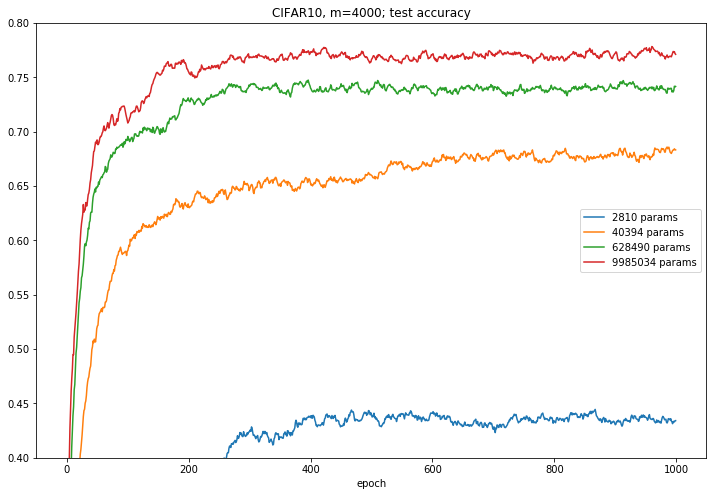

In [151]:
plt.figure(figsize=(12,8))

for num_filters in num_filters_alts:
    curve = DataFrame(np.array(test_accs[num_filters])).ewm(alpha=0.1).mean()
    plt.plot(curve)
plt.ylim(0.4, 0.8)
plt.legend(['{} params'.format(param_counts[num_filters]) for num_filters in num_filters_alts])
plt.xlabel('epoch')
plt.title('CIFAR10, m=4000; test accuracy')

Text(0.5,1,'CIFAR10, m=4000; train accuracy')

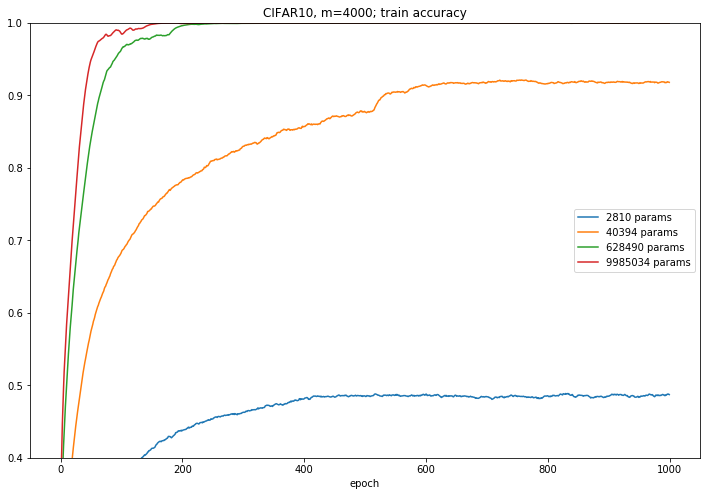

In [152]:
plt.figure(figsize=(12,8))

for num_filters in num_filters_alts:
    curve = DataFrame(np.array(train_accs[num_filters])).ewm(alpha=0.1).mean()
    plt.plot(curve)
plt.ylim(0.4, 1.0)
plt.legend(['{} params'.format(param_counts[num_filters]) for num_filters in num_filters_alts])
plt.xlabel('epoch')
plt.title('CIFAR10, m=4000; train accuracy')

Text(0.5,1,'CIFAR10, m=4000; risk difference')

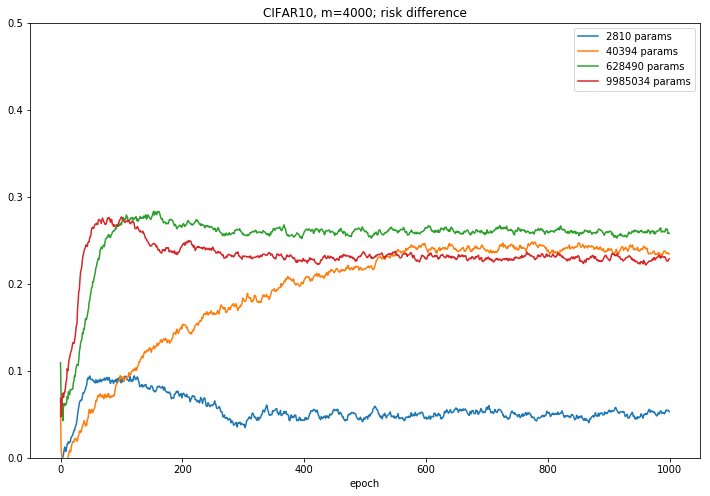

In [153]:
plt.figure(figsize=(12,8))

for num_filters in num_filters_alts:
    curve = DataFrame(np.array(train_accs[num_filters]) - np.array(test_accs[num_filters])).ewm(alpha=0.1).mean()
    plt.plot(curve)
plt.ylim(0.0, 0.5)
plt.legend(['{} params'.format(param_counts[num_filters]) for num_filters in num_filters_alts])
plt.xlabel('epoch')
plt.title('CIFAR10, m=4000; risk difference')